# Test of updated model with more convolutional layers and batch normalization
# *and* rate scheduling

We'll be using Keras with TensorFlow backend to build a skin lesion classifier. Let's start by importing the necessary libraries and setting up the directory structure.

In [1]:
#%pip install tensorflow
#%pip install keras

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8878993951094020036
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14899936281122829694
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


Next, import the necessary libraries:

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split


In [3]:


import requests

# URLs of the file chunks on GitHub
urls = [
    "https://github.com/luiscunhacsc/dl_course_datasets/blob/main/SkinDataSet.zip.001?raw=true",
    "https://github.com/luiscunhacsc/dl_course_datasets/blob/main/SkinDataSet.zip.002?raw=true",
    "https://github.com/luiscunhacsc/dl_course_datasets/blob/main/SkinDataSet.zip.003?raw=true",
    "https://github.com/luiscunhacsc/dl_course_datasets/blob/main/SkinDataSet.zip.004?raw=true",
    "https://github.com/luiscunhacsc/dl_course_datasets/blob/main/SkinDataSet.zip.005?raw=true",
    "https://github.com/luiscunhacsc/dl_course_datasets/blob/main/SkinDataSet.zip.006?raw=true",
    "https://github.com/luiscunhacsc/dl_course_datasets/blob/main/SkinDataSet.zip.007?raw=true",
]

# Download and combine the chunks
with open('combined_file.zip', 'wb') as output_file:
    for url in urls:
        response = requests.get(url, allow_redirects=True)
        output_file.write(response.content)






!unzip -q combined_file.zip
!rm combined_file.zip

Now, let's define some parameters and directory paths:

In [4]:
img_width, img_height = 224, 224
train_data_dir = 'skin_train_dataset'
test_data_dir = 'skin_test_dataset'
nb_train_samples = 3297
epochs = 50
batch_size = 32


In [5]:
#This code is only needed if the images are all in the same folder
#(i.e. not divided into "benign" and "malignant" subfolders)

#import os
#import shutil

#src_dir = 'skin_dataset_26mar2023'
#benign_dir = os.path.join(src_dir, 'benign')
#malignant_dir = os.path.join(src_dir, 'malignant')

# Create the subfolders if they don't exist
#os.makedirs(benign_dir, exist_ok=True)
#os.makedirs(malignant_dir, exist_ok=True)

# Move the benign and malignant images to their respective subfolders
#for filename in os.listdir(src_dir):
#    src_path = os.path.join(src_dir, filename)
#
#    if os.path.isfile(src_path):
#        if filename.startswith('benign'):
#            shutil.move(src_path, os.path.join(benign_dir, filename))
#        elif filename.startswith('malignant'):
#            shutil.move(src_path, os.path.join(malignant_dir, filename))


#src_dir = 'test_dataset_26mar2023'
#benign_dir = os.path.join(src_dir, 'benign')
#malignant_dir = os.path.join(src_dir, 'malignant')

# Create the subfolders if they don't exist
#os.makedirs(benign_dir, exist_ok=True)
#os.makedirs(malignant_dir, exist_ok=True)

# Move the benign and malignant images to their respective subfolders
#for filename in os.listdir(src_dir):
#    src_path = os.path.join(src_dir, filename)
#
#    if os.path.isfile(src_path):
#        if filename.startswith('benign'):
#            shutil.move(src_path, os.path.join(benign_dir, filename))
#        elif filename.startswith('malignant'):
#            shutil.move(src_path, os.path.join(malignant_dir, filename))


Depending on the image format, you may need to set the input shape for the model:

In [6]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Model architecture using the Keras functional API:

Test of updated model with more convolutional layers and batch normalization:

In [7]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

# Define the input layer
input_layer = Input(shape=input_shape)

# Create the convolutional and pooling layers
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
bn1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
bn2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

conv3 = Conv2D(128, (3, 3), activation='relu')(pool2)
bn3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

conv4 = Conv2D(256, (3, 3), activation='relu')(pool3)
bn4 = BatchNormalization()(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

conv5 = Conv2D(512, (3, 3), activation='relu')(pool4)
bn5 = BatchNormalization()(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2))(bn5)

# Flatten the output of the last pooling layer
flat = Flatten()(pool5)

# Create the dense layers
dense1 = Dense(64, activation='relu')(flat)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(1, activation='sigmoid')(dropout)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Training, validation and test data sets generators
Note that you can control for **data augmentation** usage
Data augmentation is only done in the training data set
You control that option by setting __use_data_augmentation__ to True or False

In [8]:
print("Using Directories:")
print("Train:", train_data_dir)
print("Test:", test_data_dir)

use_data_augmentation = True

if not use_data_augmentation:
    train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
else:
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.5, 1.5],
        channel_shift_range=20,
        fill_mode='nearest',
        validation_split=0.2)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

# Validation generator (augmented)
validation_datagen = train_datagen

validation_generator = validation_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

# Test data generator (non-augmented)
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)


Using Directories:
Train: skin_train_dataset
Test: skin_test_dataset
Found 2478 images belonging to 2 classes.
Found 619 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Evaluate the model on the test set:

In [9]:
test_scores = model.evaluate(test_generator, verbose=1)
print("Test accuracy: %.2f%%" % (test_scores[1] * 100))


7/7 [==============================] - 9s 105ms/step - loss: 0.6931 - accuracy: 0.4700
Test accuracy: 47.00%


Create a ModelCheckpoint instance and specify the file path, the metric to monitor, and the mode (maximize or minimize the metric):

This code will save the best model based on the validation accuracy during training.
The save_best_only=True argument ensures that only the model with the best performance so far is saved.
Note that the file "best_skin_lesion_classifier_28mar_4.h5" will be overwritten whenever a better model is found during training.
The verbose=1 argument provides updates whenever a new best model is saved.

In [10]:
checkpoint_filepath = 'best_skin_lesion_classifier_28mar_4.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

This callback will monitor a specified metric (usually validation loss or accuracy) and stop training when the metric
does not improve for a given number of consecutive epochs. This helps to avoid overfitting and reduce training time.

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


Add learning rate scheduling (note that the patience for early stopping has to be changes in a way compatible to the patience in the LRS callback):

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)


Train the model using the fit method and retain the training history:

In [13]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint, early_stopping, reduce_lr])


Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 1.4469 - accuracy: 0.6619
Epoch 1: val_accuracy improved from -inf to 0.50493, saving model to best_skin_lesion_classifier_28mar_4.h5
77/77 [==============================] - 59s 661ms/step - loss: 1.4469 - accuracy: 0.6619 - val_loss: 0.6927 - val_accuracy: 0.5049 - lr: 0.0010
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.7905 - accuracy: 0.6975
Epoch 2: val_accuracy improved from 0.50493 to 0.54441, saving model to best_skin_lesion_classifier_28mar_4.h5
77/77 [==============================] - 49s 640ms/step - loss: 0.7905 - accuracy: 0.6975 - val_loss: 1.9160 - val_accuracy: 0.5444 - lr: 0.0010
Epoch 3/50
77/77 [==============================] - ETA: 0s - loss: 0.5299 - accuracy: 0.7445
Epoch 3: val_accuracy improved from 0.54441 to 0.54934, saving model to best_skin_lesion_classifier_28mar_4.h5
77/77 [==============================] - 49s 641ms/step - loss: 0.5299 - accuracy: 0.7445 - val_lo

Evaluate the model on the test set:

In [14]:
test_scores = model.evaluate(test_generator, verbose=1)
print("Test accuracy: %.2f%%" % (test_scores[1] * 100))


7/7 [==============================] - 1s 113ms/step - loss: 0.3090 - accuracy: 0.8750
Test accuracy: 87.50%


Evaluate the model on the validation and test sets:

In [15]:
# Validation set
validation_scores = model.evaluate(validation_generator, verbose=1)
print("Validation accuracy: %.2f%%" % (validation_scores[1] * 100))

# Test set
test_scores = model.evaluate(test_generator, verbose=1)
print("Test accuracy: %.2f%%" % (test_scores[1] * 100))

20/20 [==============================] - 9s 453ms/step - loss: 0.3207 - accuracy: 0.8449
Validation accuracy: 84.49%
7/7 [==============================] - 1s 83ms/step - loss: 0.3090 - accuracy: 0.8750
Test accuracy: 87.50%


Make predictions and compare them to the true labels:

In [16]:
# Predictions for test set
predictions = model.predict(test_generator)
predicted_classes = np.round(predictions)  # Round predictions to obtain class labels

# Get true labels
true_classes = test_generator.classes

# Compare predicted_classes and


7/7 [==============================] - 1s 113ms/step


With this implementation, you can train your model, and the best version will be saved based on the highest validation accuracy observed during training.
Once the training is finished, you can load the best model using the following code:

In [17]:
from tensorflow.keras.models import load_model

best_model = load_model('best_skin_lesion_classifier_28mar_4.h5')


You can then evaluate the performance of the best model on the test set:

In [18]:
test_scores = best_model.evaluate(test_generator, verbose=1)
print("Test accuracy: %.2f%%" % (test_scores[1] * 100))


7/7 [==============================] - 1s 82ms/step - loss: 0.3139 - accuracy: 0.8700
Test accuracy: 87.00%


Plot training history:

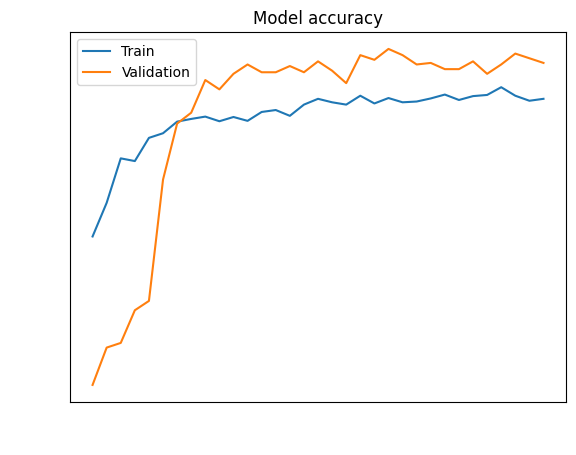

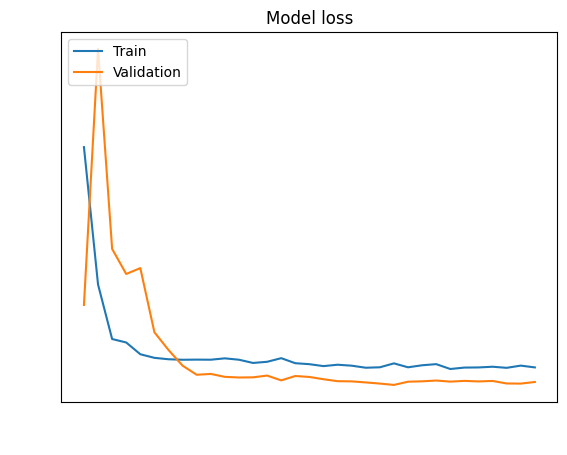

In [19]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy', color='white')
    plt.xlabel('Epoch', color='white')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tick_params(axis='both', colors='white')  # Added this line
    plt.show()

    # Plot training & validation loss values
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss', color='white')
    plt.xlabel('Epoch', color='white')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tick_params(axis='both', colors='white')  # Added this line
    plt.show()

plot_training_history(history)

